# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import *
from src.utils import *
from src.recommenders import MainRecommender

In [221]:
data = pd.read_csv('../../retail_train.csv')
item_features = pd.read_csv('../../product.csv')
user_features = pd.read_csv('../../hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [222]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [223]:
recommender = MainRecommender(data_train_lvl_1, weighting=True, k1=10)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [224]:
recommender.get_als_recommendations(2375, N=5)

[1081177, 854852, 899624, 1044078, 844179]

In [225]:
recommender.get_own_recommendations(2375, N=5)

[907099, 899624, 5585510, 1106523, 999104]

In [226]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1042907, 1127831, 1081177, 1029743]

In [227]:
recommender.get_similar_users_recommendation(2375, N=5)

[1092937, 986912, 915064, 1101010, 1029743]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [228]:
def rule(x, y, model, N=5):
    if x in y:
        return recommender.overall_top_purchases[:N]
    if model == 'als':
        return recommender.get_als_recommendations(x, N=N)
    elif model == 'own':
        return recommender.get_own_recommendations(x, N=N)
    elif model == 'similar_items':
        return recommender.get_similar_items_recommendation(x, N=N)
    elif model == 'similar_users':
        return recommender.get_similar_users_recommendation(x, N=N)
    elif model == 'bayesian':
        return recommender.get_bayesian_recommendations(x, N=N)

def get_self_top_purchases(user_id, N=5):
    return recommender.top_purchases[recommender.top_purchases.user_id == user_id].item_id.head(N).tolist()

In [194]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [229]:
cold_users = data_val_lvl_1.loc[~data_val_lvl_1.user_id.isin(data_train_lvl_1.user_id), 'user_id'].unique().tolist()
cold_users

[1813, 1273, 1355, 1679, 1984, 2010, 1644, 296, 814, 2348]

In [233]:
num_candidates_list = [5, 10, 50, 100, 200, 500, 1000]
recalls_own = []

result_lvl_1['own_1000'] = result_lvl_1['user_id'].apply(lambda x: rule(x, cold_users, model='own', N=1000))

for k in num_candidates_list:
    recalls_own.append(result_lvl_1.apply(lambda row: recall_at_k(row['own_1000'], row['actual'], k=k), axis=1).mean())

In [234]:
recalls_als = []

result_lvl_1['als_1000'] = result_lvl_1['user_id'].apply(lambda x: rule(x, cold_users, model='als', N=1000))

for k in num_candidates_list:
    recalls_als.append(result_lvl_1.apply(lambda row: recall_at_k(row['als_1000'], row['actual'], k=k), axis=1).mean())

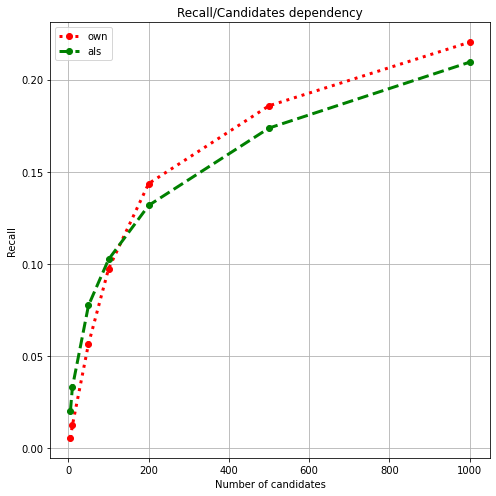

In [235]:
plt.figure(figsize=(7,7))
plt.title('Recall/Candidates dependency')
plt.plot(num_candidates_list, recalls_own, ls=':', color='red', lw=3, label='own', marker='o')
plt.plot(num_candidates_list, recalls_als, ls='--', color='green', lw=3, label='als', marker='o')
plt.ylabel('Recall')
plt.xlabel('Number of candidates')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Интуитивно кажется, что оптимальное количество кандидатов должно быть не слишком большим и не слишком маленьким. По графику можно предположить, что оптимальное значение может находиться в точке перегиба графика функции - где резкий рост recall сменяется более пологим.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [261]:
new = data_train_lvl_2.loc[~data_train_lvl_2.user_id.isin(data_train_lvl_1.user_id), 'user_id'].unique().tolist()
new

[1813, 1273, 1355, 1679, 1984, 2010, 1644, 296, 814, 2348]

In [262]:
df_candidates = pd.DataFrame(data=data_train_lvl_2['user_id'].unique().tolist())
df_candidates.columns = ['user_id']
df_candidates['candidates'] = df_candidates['user_id'].apply(lambda x: rule(x, new, model='own', N=20))
df_candidates.head()

,user_id,candidates
0,2070,"[983584, 999270, 944588, 928263, 865456, 55876..."
1,2021,"[1131438, 1104649, 1019142, 1012587, 842423, 1..."
2,1753,"[965693, 916122, 12648296, 12692328, 912704, 1..."
3,2120,"[1029743, 1029743, 1106523, 5569230, 916122, 8..."
4,1346,"[1124732, 5584646, 5569993, 1063577, 916122, 8..."


In [263]:
df_candidates = pd.DataFrame({'user_id': df_candidates['user_id'].values.repeat(20),
                              'item_id': np.concatenate(df_candidates['candidates'].values)})

df_train = data_train_lvl_2[['user_id', 'item_id']].copy()
df_train['target'] = 1

df_train = df_candidates.merge(df_train, on=['user_id', 'item_id'], how='left')
df_train.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)

df_train['target'].fillna(0, inplace=True)
df_train.head()

,user_id,item_id,target
0,2070,983584,0.0
1,2070,999270,0.0
2,2070,944588,0.0
3,2070,928263,0.0
4,2070,865456,1.0


In [264]:
df_train['target'].value_counts(normalize=True)

0.0    0.81267
1.0    0.18733
Name: target, dtype: float64

In [265]:
df_train = df_train.merge(item_features, on='item_id', how='left')
df_train = df_train.merge(user_features, on='user_id', how='left')
df_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,983584,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,999270,0.0,1425,MEAT-PCKGD,National,BACON,ECONOMY,1 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [266]:
train_val_lvl1 = pd.concat([data_train_lvl_1, data_val_lvl_1])

train_val_lvl1 = train_val_lvl1.merge(item_features[['item_id', 'department']], on='item_id', how='left')

In [267]:
def create_multiple_features(df_train, train_val_lvl1=train_val_lvl1):
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('user_id').count().rename('item_freq'), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('user_id').count().rename('user_freq'), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('sales_value').sum().rename('total_user_sales_value'), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_week')/train_val_lvl1.week_no.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_week')/train_val_lvl1.week_no.nunique(), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='user_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='item_id').agg('user_id').count().rename('item_freq_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='item_id')
    df_train = df_train.merge(train_val_lvl1.groupby(by='user_id').agg('user_id').count().rename('user_freq_per_basket')/train_val_lvl1.basket_id.nunique(), how='left',on='user_id')
    return df_train

In [268]:
def create_user_features(df_train, data_train=train_val_lvl1):

    # Средний чек
    users_sales = data_train.groupby('user_id')['sales_value'].mean().reset_index()
    users_sales.rename(columns={'sales_value': 'avg_cheque'}, inplace=True)
    df_train = df_train.merge(users_sales[['user_id', 'avg_cheque']], on='user_id', how='left')

    # Количество уникальных категорий покупателя
    users_departments = data_train.groupby('user_id')['department'].nunique().reset_index()
    users_departments.rename(columns = {'department':'users_unique_departments'}, inplace=True)
    df_train = df_train.merge(users_departments, on='user_id', how='left')

    # Среднее время покупки
    bought_time = data_train.groupby('user_id')['trans_time'].mean().reset_index()
    bought_time.rename(columns = {'trans_time':'mean_trans_time_by_user'}, inplace=True)
    df_train = df_train.merge(bought_time, on='user_id', how='left')

    # Средний чек корзины 
    baskets_sales_value = data_train.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
    mean_basket_sales_value = baskets_sales_value.groupby('user_id')['sales_value'].mean().reset_index()
    mean_basket_sales_value.rename(columns = {'sales_value':'mean_sales_value_per_basket'}, inplace=True)
    df_train = df_train.merge(mean_basket_sales_value, on='user_id', how='left')

    # Количество купленных уникальных товаров 
    unique_bought_items = data_train.groupby('user_id')['item_id'].nunique().reset_index()
    unique_bought_items.rename(columns = {'item_id':'unique_bought_items'}, inplace=True)
    df_train = df_train.merge(unique_bought_items, on='user_id', how='left')

    # Среднее количество уникальных категорий в корзине
    users_baskets = data_train.groupby(['user_id', 'basket_id'])['department'].nunique().reset_index()
    users_baskets = users_baskets.groupby('user_id')['department'].mean().reset_index()
    users_baskets.rename(columns={'department': 'avg_basket_department'}, inplace=True)
    df_train = df_train.merge(users_baskets[['user_id', 'avg_basket_department']], on='user_id', how='left')

    # Средняя сумма покупки в категории
    department_sales = data_train.groupby('department')['sales_value'].mean().reset_index()
    department_sales.rename(columns={'sales_value': 'mean_sales_value_category'}, inplace=True)
    df_train = df_train.merge(department_sales, on='department', how='left')

    # Средная цена купленных товаров пользователем
    users_sales = data_train.groupby('user_id')[['sales_value', 'quantity']].sum().reset_index()
    users_sales['avg_price'] = users_sales['sales_value'] / users_sales['quantity']
    df_train = df_train.merge(users_sales[['user_id', 'avg_price']], on='user_id', how='left')
    return df_train

In [269]:
def create_item_features(df_train, train_val_lvl1=train_val_lvl1):    

    # Среднее количество покупок товара в неделю
    num_purchase_week = train_val_lvl1.groupby('item_id').agg({'week_no': 'nunique', 'quantity': 'sum'}).reset_index()
    num_purchase_week['avg_num_purchases_week'] = num_purchase_week['quantity'] / num_purchase_week['week_no']
    df_train = df_train.merge(num_purchase_week[['item_id', 'avg_num_purchases_week']], on='item_id', how='left')
    df_train['avg_num_purchases_week'].fillna(0, inplace=True)

    # Цена товара
    items_sales = train_val_lvl1.groupby('item_id')[['sales_value', 'quantity']].sum().reset_index()
    items_sales['price'] = items_sales['sales_value'] / items_sales['quantity']
    items_sales['price'].fillna(0, inplace=True)
    df_train = df_train.merge(items_sales[['item_id', 'price']], on='item_id', how='left')

    # Среднее время покупки товара
    bought_item_time = train_val_lvl1.groupby('item_id')['trans_time'].mean().reset_index()   
    bought_item_time.rename(columns = {'trans_time':'mean_trans_time_by_item'}, inplace=True)
    df_train = df_train.merge(bought_item_time, on = 'item_id', how = 'left')

    # Количество магазинов, где есть товар
    items_stores = train_val_lvl1.groupby('item_id')['store_id'].sum().reset_index()
    items_stores.rename(columns={'store_id': 'n_stores_with_item'}, inplace=True)
    items_stores['n_stores_with_item'].fillna(0, inplace = True)
    df_train = df_train.merge(items_stores, on='item_id', how='left')

    # Количество уникальных магазинов, где есть товар
    items_stores = train_val_lvl1.groupby('item_id')['store_id'].nunique().reset_index()
    items_stores.rename(columns={'store_id': 'n_unique_stores_with_item'}, inplace=True)
    items_stores['n_unique_stores_with_item'].fillna(0, inplace = True)
    df_train = df_train.merge(items_stores, on='item_id', how='left')
    return df_train

In [270]:
def get_new_features(train_val_lvl1):
    
    # час совершения транзакции
    data = train_val_lvl1.copy()
    data['hour'] = data['trans_time'] // 100
    user_item_features = data.groupby(['user_id', 'item_id'])['hour'].median().reset_index()
    user_item_features.columns = ['user_id', 'item_id', 'median_sales_hour']
    
    # день недели совершения транзакции
    data['weekday'] = data['day'] % 7
    df = data.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
    df.columns = ['user_id', 'item_id', 'median_weekday']
    user_item_features = user_item_features.merge(df, on=['user_id', 'item_id'])
    
    # cреднее кол-во дней между покупками
    df = data.groupby('user_id')['day'].nunique().reset_index()
    df['mean_visits_interval'] = (data.groupby('user_id')['day'].max() - data.groupby('user_id')['day'].min()) / df['day']
    user_item_features = user_item_features.merge(df[['user_id', 'mean_visits_interval']], on=['user_id'])
    
    # кол-во транзакций клиента
    df = data.groupby(['user_id'])['item_id'].count().reset_index()
    df.columns = ['user_id', 'n_transactions']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # mean / max / std кол-ва уникальных товаров в корзине клиента
    df = data.groupby(['user_id', 'basket_id'])['item_id'].nunique().reset_index()
    df1 = df.groupby('user_id')['item_id'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_items_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['item_id'].max().reset_index()
    df2.columns = ['user_id', 'max_n_items_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['item_id'].std().reset_index()
    df3.columns = ['user_id', 'std_n_items_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    # mean / max / std кол-ва уникальных категорий в корзине клиента
    data = data.merge(item_features[['item_id', 'commodity_desc']], on=['item_id'])
    df = data.groupby(['user_id', 'basket_id'])['commodity_desc'].nunique().reset_index()
    df1 = df.groupby('user_id')['commodity_desc'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_item_categories_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['commodity_desc'].max().reset_index()
    df2.columns = ['user_id', 'max_n_item_categories_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['commodity_desc'].std().reset_index()
    df3.columns = ['user_id', 'std_n_item_categories_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])
    
    return user_item_features

In [271]:
df_train = create_multiple_features(df_train)
df_train = create_user_features(df_train)
df_train = create_item_features(df_train)
df_train = df_train.merge(get_new_features(train_val_lvl1), on=['user_id', 'item_id'], how='left')

In [272]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        df_train[column].fillna('unk', inplace=True)
    elif df_train[column].dtype in ['float64', 'float32']: 
        df_train[column].fillna(0.0, inplace=True)
print(f'Length of train data: {df_train.shape[0]}')
df_train.dropna(inplace=True)
df_train = reduce_memory(df_train)

Length of train data: 42764


In [273]:
X, y = df_train.drop('target', axis=1), df_train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cat_cols = X.select_dtypes(include=['category']).columns.tolist()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [274]:
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 2,
                'use_best_model': True,
                'early_stopping_rounds': 50,
                'allow_writing_files': False,
                'random_seed': 42,
                'depth': 8, 
                'learning_rate': 0.06318730785749581, 
                'l2_leaf_reg': 3.7381801866358395, 
                'bagging_temperature': 3.0990257265289514, 
                'subsample': 0.7159725093210578, 
                'colsample_bylevel': 0.5038603981386294, 
                'boosting_type': 'Plain', 
                'auto_class_weights': 'SqrtBalanced', 
                'grow_policy': 'Lossguide', 
                'min_data_in_leaf': 55, 
                'max_leaves': 35
}

In [275]:
%%time
X_ = X.copy()
train_pool = Pool(X_, y, cat_features=cat_cols)

cat = CatBoostClassifier(**params_model).fit(train_pool, eval_set=train_pool)

print(f'ROC_AUC: ', f'{roc_auc_score(y, cat.predict_proba(X)[:,1]):.4f}')

ROC_AUC:  0.9964
CPU times: total: 16min 18s
Wall time: 5min 49s


In [276]:
rank_results = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
rank_results.columns = ['user_id', 'actual']
cold_users = data_val_lvl_2.loc[~data_val_lvl_2.user_id.isin(data_train_lvl_1.user_id.tolist()), 'user_id'].unique().tolist()

rank_results['own'] = rank_results['user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [277]:
df_predict = df_train.copy()
df_predict['proba_item_purchase'] = cat.predict_proba(X)[:, 1]

In [278]:
def rerank(user_id, N, out=cold_users):
    if user_id in df_predict.user_id:
        return df_predict[df_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(N).item_id.tolist()
    else:
        return get_self_top_purchases(user_id)

In [279]:
rank_results['reranked_own'] = rank_results['user_id'].apply(lambda user_id: rerank(user_id, N=5))

In [280]:
cold_users = data_val_lvl_2.loc[~data_val_lvl_2.user_id.isin(data_train_lvl_1.user_id.tolist()), 'user_id'].unique().tolist()

rank_results.loc[rank_results['reranked_own'].str.len() == 0, 'reranked_own'] = rank_results.\
    loc[rank_results['reranked_own'].str.len() == 0, 'user_id'].apply(lambda x: get_self_top_purchases(x))

rank_results.loc[rank_results['reranked_own'].str.len() == 0, 'reranked_own'] = rank_results.\
    loc[rank_results['reranked_own'].str.len() == 0, 'user_id'].apply(lambda x: rule(x, cold_users, model='own', N=5))

In [281]:
print('-'*15, 'mean precision@5', '-'*15)

for pred in calc_precision_at_k(rank_results, 5):
    print(*pred, sep=': ')

--------------- mean precision@5 ---------------
own: 27.091087169441725
reranked_own: 28.02644466209599


### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 